In [19]:
import glob
from PIL import Image

import numpy as np
from transformers import AutoModel, AutoFeatureExtractor

from google.cloud import aiplatform as vertex

In [84]:
REGION = 'asia-southeast1'
PROJECT_ID = 'mitochondrion-project-344303'

vertex.init(project='mitochondrion-project-344303', location='asia-southeast1')

In [ ]:
# get embedding from vertex

In [97]:
# get embedding from huggingface
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = AutoModel.from_pretrained(model_checkpoint)

processor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

def get_embedding_hf(img):
    
    inputs = processor(img, return_tensors='pt')
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0].detach().numpy()[0, :]
    
    return embedding

In [98]:
# prepare data for indexing

In [ ]:
clothes = glob.glob('img/**/*.jpg', recursive=True)

In [7]:
len(clothes)

52712

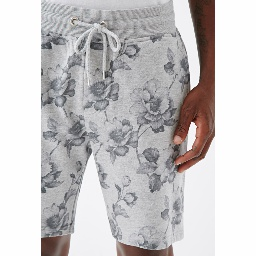

In [10]:
image = Image.open(clothes[0])
image

In [32]:
# Loop through sample images
embeds = np.zeros((10, 768))

for i, c in enumerate(clothes[:10]):
    image = Image.open(c)
    em = get_embedding_hf(image)

    # print(em.shape)
    embeds[i, :] = em

In [33]:
# test run query with one image

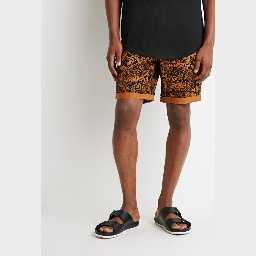

In [34]:
test_image = Image.open(clothes[10])
test_image

In [35]:
test_embed = get_embedding(test_image)

In [42]:
scores = np.sqrt(np.dot(embeds, test_embed))/(np.linalg.norm(embeds)*np.linalg.norm(test_embed))

In [43]:
scores

array([0.04916576, 0.05222555, 0.0514712 , 0.050123  , 0.04205476,
       0.05554317, 0.04602132, 0.04752925, 0.04366247, 0.04810713])

In [46]:
winner = np.argmax(scores)

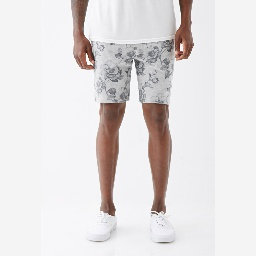

In [48]:
winner_image = Image.open(clothes[winner])
winner_image

In [45]:
# build index

In [72]:
num_data = 10000

f = open('embedding1000.csv', 'w')

for i, c in enumerate(clothes[:num_data]):
    image = Image.open(c)
    em = get_embedding(image)
    f.write(f'{c},{",".join([str(x) for x in em.tolist()])}\n')

f.close()


In [75]:
clothes_index100 = vertex.MatchingEngineIndex(
    index_name = '6749928271195930624'
)

In [73]:
clothes_index = vertex.MatchingEngineIndex.create_tree_ah_index(
    display_name='',
    contents_delta_uri='gs://mitochondrion-demo/dataset/tabular/matching2/',
    dimensions=768,
    approximate_neighbors_count=100,
    distance_measure_type='DOT_PRODUCT_DISTANCE',
    leaf_node_embedding_count=300,
    leaf_nodes_to_search_percent=7,
    description='Clothes 1000 index'
)

# gs://mitochondrion-demo/dataset/tabular/matching2/embedding1000.csv

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/832137092875/locations/asia-southeast1/indexes/244478609459249152/operations/1901997885889708032


KeyboardInterrupt: 

In [62]:
# %%bash
# gcloud ai indexes create \
#   --metadata-file=index_metadata.json \
#   --display-name=clothes_index \
#   --project=mitochondrion-project-344303 \
#   --region=asia-southeast1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ERROR: (gcloud.ai.indexes.create) FAILED_PRECONDITION: The Cloud Storage bucket of `gs://mitochondrion-demo/dataset/tabular/matching_engine/` is in location `asia-southeast1`. It must be in the same regional location as the service location `us-central1`.


CalledProcessError: Command 'b'gcloud ai indexes create \\\n  --metadata-file=index_metadata.json \\\n  --display-name=clothes_index \\\n  --project=mitochondrion-project-344303 \\\n  --region=us-central1\n'' returned non-zero exit status 1.

In [68]:
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID: '{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]
PROJECT_NUMBER

'832137092875'

In [70]:
VPC_NETWORK = 'mitochondrion-vpc'
VPC_NETWORK_FULL = f'projects/{PROJECT_NUMBER}/global/networks/{VPC_NETWORK}'
VPC_NETWORK_FULL

'projects/832137092875/global/networks/mitochondrion-vpc'

In [ ]:
# create public indexEndpoint

In [ ]:
%%bash
curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    -d @request.json \
    "https://LOCATION-aiplatform.googleapis.com/v1/projects/PROJECT/locations/LOCATION/indexEndpoints"

In [77]:
indexEndpoint100 = vertex.MatchingEngineIndexEndpoint(
    index_endpoint_name = '5302707086252048384'
)

In [ ]:
# create private indexEndpoint

In [71]:
%%bash
gcloud ai index-endpoints create \
  --display-name=private_clothes_index_endpoint \
  --network=projects/832137092875/global/networks/mitochondrion-vpc \
  --project=mitochondrion-project-344303 \
  --region=asia-southeast1

Using endpoint [https://asia-southeast1-aiplatform.googleapis.com/]
Waiting for operation [5141211917875937280]...
...................................done.
Created Vertex AI index endpoint: projects/832137092875/locations/asia-southeast1/indexEndpoints/5302707086252048384.


In [ ]:
# deploy index to endpoint

In [86]:
PEERING_RANGE_NAME = 'ann-range'
NETWORK_NAME = 'mitochondrion-vpc'

In [87]:
! gcloud compute addresses create {PEERING_RANGE_NAME} --global --prefix-length=16 --network={NETWORK_NAME} --purpose=VPC_PEERING --project={PROJECT_ID} --description="peering range for Matching Engine."


Created [https://www.googleapis.com/compute/v1/projects/mitochondrion-project-344303/global/addresses/ann-range].


In [88]:
! gcloud services vpc-peerings connect --service=servicenetworking.googleapis.com --network={NETWORK_NAME} --ranges={PEERING_RANGE_NAME} --project={PROJECT_ID}


Operation "operations/pssn.p24-832137092875-2aafee1a-264c-4d01-b2b1-b551eb3a046d" finished successfully.


In [79]:
DEPLOYED_INDEX_ID = 'clothe100_deployed_index1234'

In [89]:
indexEndpoint100.deploy_index(
    index=clothes_index100, deployed_index_id=DEPLOYED_INDEX_ID
)

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/832137092875/locations/asia-southeast1/indexEndpoints/5302707086252048384
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/832137092875/locations/asia-southeast1/indexEndpoints/5302707086252048384/operations/8681041224989147136
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/832137092875/locations/asia-southeast1/indexEndpoints/5302707086252048384


resource name: projects/832137092875/locations/asia-southeast1/indexEndpoints/5302707086252048384

In [93]:
query = np.random.uniform(size=(768))

In [96]:
response = indexEndpoint100.match(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[query],
    num_neighbors=5
)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1685445471.400710506","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","file_line":3260,"referenced_errors":[{"created":"@1685445471.400710176","description":"failed to connect to all addresses","file":"src/core/lib/transport/error_utils.cc","file_line":167,"grpc_status":14}]}"
>

In [ ]:
%%bash
gcloud ai index-endpoints deploy-index 5302707086252048384 \
  --deployed-index-id=deployed-index-1234 \
  --display-name=clothes-index-endpoint \
  --index=6749928271195930624 \
  --project=mitochondrion-project-344303 \
  --region=asia-southeast1

In [ ]:
# Get the index domain name

In [ ]:
curl -H "Content-Type: application/json" -H "Authorization: Bearer `gcloud auth print-access-token`"  ${ENDPOINT}/v1/projects/${PROJECT_ID}/locations/${REGION}/indexEndpoints/${INDEX_ENDPOINT_ID}

In [ ]:
# query to index

In [ ]:
%%bash
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer `gcloud auth print-access-token`"  https://1957880287.us-central1-181224308459.vdb.vertexai.goog/v1beta1/projects/181224308459/locations/us-central1/indexEndpoints/3370566089086861312:findNeighbors -d '{deployed_index_id: "test_index_public1", queries: [{datapoint: {datapoint_id: "0", feature_vector: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, neighbor_count: 5}]}'


In [50]:
from google.oauth2 import service_account
import google.cloud.aiplatform.aiplatform_v1beta1 as aiplatform_v1beta1
 
def findneighbor_sample():
  # The AI Platform services require regional API endpoints.
  scopes = ["https://www.googleapis.com/auth/cloud-platform"]
  
  # create a service account with `Vertex AI User` role granted in IAM page.
  # download the service account key https://developers.google.com/identity/protocols/oauth2/service-account#authorizingrequests
  sa_file_path = "/usr/local/google/home/user1/sa-ac2a3da46dea.json"
 
  credentials = service_account.Credentials.from_service_account_file(
      sa_file_path, scopes=scopes
  )
  client_options = {
      "api_endpoint": "102531040.us-central1-145252452137.vdb.vertexai.goog"
  }
 
  vertex_ai_client = aiplatform_v1beta1.MatchServiceClient(
      credentials=credentials,
      client_options=client_options,
  )
 
  request = aiplatform_v1beta1.FindNeighborsRequest(
      index_endpoint="projects/145252452137/locations/us-central1/indexEndpoints/332536296704573440",
      deployed_index_id="test_index_public1",
  )
  dp1 = aiplatform_v1beta1.IndexDatapoint(
      datapoint_id="0",
      feature_vector=[
          1,
          1,
          1,
          1
      ],
  )
  query = aiplatform_v1beta1.FindNeighborsRequest.Query(
      datapoint=dp1,
  )
  request.queries.append(query)
 
  response = vertex_ai_client.find_neighbors(request)
 
  print(response)

ModuleNotFoundError: No module named 'google.cloud.aiplatform.aiplatform_v1beta1'